# Final Project Presentation


In [95]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



dataset_url = 'https://raw.githubusercontent.com/samofuture/ML-Final-Project/main/dataset.csv'


## Preparing the Data
We assign the text 'Graduate', 'Enrolled', and 'Dropout' to the integers 2, 1, and 0 respectively.

In [3]:
def prep_data() -> pd.DataFrame:
    df = pd.read_csv(dataset_url)
    df['Target'] = df['Target'].apply(lambda x: 2 if x == 'Graduate' else 1 if x == 'Enrolled' else 0)
    return df

In [4]:
df = prep_data()
target = df.pop('Target').to_numpy()
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,6,1,11,1,1,1,1,3,4,...,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,5,1,1,1,22,27,10,...,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,8,2,15,1,1,1,23,27,6,...,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,12,1,3,0,1,1,22,28,10,...,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,1,6,...,0,0,6,8,5,12.666667,0,15.5,2.8,-4.06
4420,1,1,2,15,1,1,19,1,1,10,...,0,0,6,6,2,11.000000,0,11.1,0.6,2.02
4421,1,1,1,12,1,1,1,22,27,10,...,0,0,8,9,1,13.500000,0,13.9,-0.3,0.79
4422,1,1,1,9,1,1,1,22,27,8,...,0,0,5,6,5,12.000000,0,9.4,-0.8,-3.12


## Creating the Model
The model below is a neural network with a variable number of inputs. In our final model we decided to pass all of the inputs into the model. It has three hidden layers, with 64 -> 32 -> 16 outputs, and then generates 3 outputs (one for each class). It uses the ReLU activation function between all of the layers.

In [5]:
def new_model(num_inputs, num_outputs = 3):
    layer_1 = 64
    layer_2 = 32
    layer_3 = 16
    model = nn.Sequential(
        nn.Linear(num_inputs, layer_1),
        nn.ReLU(),
        nn.Linear(layer_1, layer_2),
        nn.ReLU(),
        nn.Linear(layer_2, layer_3),
        nn.ReLU(),
        nn.Linear(layer_3, num_outputs)
    )
    return model

### Validation
This is a very simple validation method that takes in the inputs of the model, the expected outputs of the model, and the model itself. It returns a float representing the percentage that it got correct.

In [18]:
def validate(trained_model, val_inputs, val_outputs):
    raw_outputs = trained_model(val_inputs)
    _, predicted_classes = torch.max(raw_outputs, 1)

    total_num = len(raw_outputs)
    num_correct = 0
    for i in range(len(predicted_classes)):
        if predicted_classes[i] == val_outputs[i]:
            num_correct += 1
    return num_correct / total_num

### Training Loop
This is the loop that trains the model. It requires the number of epochs, an optimizer, a loss function, the model itself, and the training and validation datasets.

In [74]:
def training_loop(num_epochs, optimizer, loss_fn, model, t_in, t_out, v_in, v_out):
    valid_acc: list[float] = []
    valid_losses: list[float] = []
    train_acc: list[float] = []
    train_losses: list[float] = []

    for epoch in range(1, num_epochs+1):
        t_p = model(t_in)
        train_loss = loss_fn(t_p, t_out.squeeze())
        train_losses.append(float(train_loss))
        v_p = model(v_in)
        val_loss = loss_fn(v_p, v_out.squeeze())
        valid_losses.append(float(val_loss))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        t_acc = validate(model, t_in, t_out)
        train_acc.append(t_acc)

        val_acc = validate(model, v_in, v_out)
        valid_acc.append(val_acc)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}:")
            print(f"\tTraining Loss: {float(train_loss)}")
            print(f"\tValidation Loss: {float(val_loss)}")
            print(f"\tValidation Accuracy: {float(val_acc)}")


    x_range = range(num_epochs)
    plt.plot(x_range, valid_acc, label='Validation Accuracy')
    plt.plot(x_range, train_acc, label='Training Accuracy')

    plt.title('Validation/Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(x_range, valid_losses, label='Validation Loss')
    plt.plot(x_range, train_losses, label='Training Loss')

    plt.title('Validation/Training Losses per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

## PCA Analysis
Early on, we wanted to know what the most important features were in our dataset. To find the most important features, we used PCA and found which components were the most important.

In [26]:
pca = PCA(n_components=20)
# pca = PCA(0.9)
model = pca.fit(df)
principalComponents = pca.fit_transform(df)
print(model.explained_variance_ratio_)
print(sum(model.explained_variance_ratio_))
n_pcs= model.components_.shape[0]
pc_list = [f'pc{i}' for i in range(n_pcs)]
principalDf = pd.DataFrame(data = principalComponents, columns=pc_list)


most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

og_names = list(df.columns)
print(most_important)
most_important_names = [og_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
dic2 = {'PC{}'.format(i+1): most_important[i] for i in range(n_pcs)}

# build the dataframe
pca_df = pd.DataFrame(sorted(dic.items()))
pca_df['Most_Important'] = pd.Series(most_important)

# pca_df
pd.DataFrame(pca.components_,columns=df.columns,index =pc_list).head()
pca_df

[0.32919208 0.15304521 0.13408989 0.08841572 0.06323148 0.04729981
 0.0369602  0.03387517 0.02068367 0.02051587 0.01630862 0.00940626
 0.00829342 0.00770076 0.00628936 0.00571968 0.00389894 0.00366899
 0.00277125 0.00262713]
0.9939935279608882
[8, 29, 17, 7, 10, 17, 1, 3, 27, 5, 31, 9, 23, 33, 6, 6, 19, 32, 2, 28]


,0,1,Most_Important
0,PC1,Father's qualification,8
1,PC10,Previous qualification,29
2,PC11,Unemployment rate,17
3,PC12,Mother's occupation,7
4,PC13,Curricular units 1st sem (grade),10
5,PC14,GDP,17
6,PC15,Nacionality,1
7,PC16,Nacionality,3
8,PC17,Curricular units 1st sem (credited),27
9,PC18,Inflation rate,5


## Training the Model

Epoch 100:
	Training Loss: 1.1273466348648071
	Validation Loss: 1.1295647621154785
	Validation Accuracy: 0.28361581920903955
Epoch 200:
	Training Loss: 1.02020263671875
	Validation Loss: 1.0226619243621826
	Validation Accuracy: 0.5898305084745763
Epoch 300:
	Training Loss: 0.8606579899787903
	Validation Loss: 0.869411826133728
	Validation Accuracy: 0.6994350282485876
Epoch 400:
	Training Loss: 0.7369989156723022
	Validation Loss: 0.7559731006622314
	Validation Accuracy: 0.7084745762711865
Epoch 500:
	Training Loss: 0.6706302762031555
	Validation Loss: 0.6971656680107117
	Validation Accuracy: 0.7288135593220338
Epoch 600:
	Training Loss: 0.6313571929931641
	Validation Loss: 0.6629713773727417
	Validation Accuracy: 0.7322033898305085
Epoch 700:
	Training Loss: 0.6051550507545471
	Validation Loss: 0.6427372097969055
	Validation Accuracy: 0.7401129943502824
Epoch 800:
	Training Loss: 0.586079478263855
	Validation Loss: 0.6298472881317139
	Validation Accuracy: 0.7435028248587571
Epoch 900:


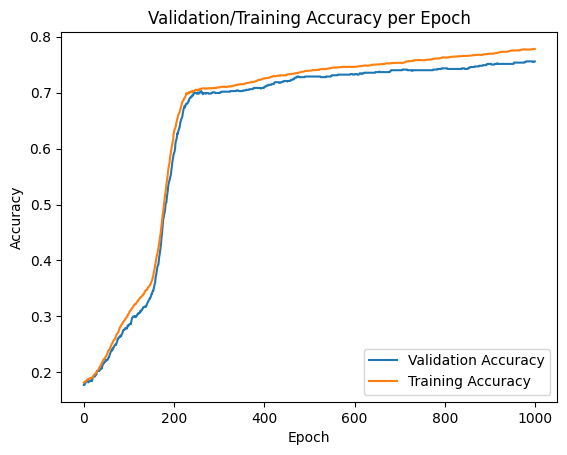

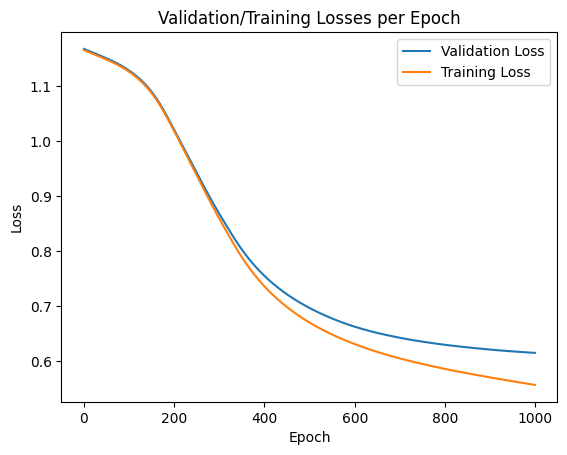

In [93]:
scaler_x = StandardScaler()
data = scaler_x.fit_transform(df)

X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2, random_state=15)

train_inputs = torch.tensor(np.array(X_train)).float()
train_outputs = torch.tensor(Y_train).long()
val_inputs = torch.tensor(np.array(X_test)).float()
val_outputs = torch.tensor(Y_test).long()

model = new_model(34)
optimizer = optim.Adam(model.parameters(), lr=0.000075)
loss_fn = nn.CrossEntropyLoss()

trained_model = training_loop(1000, optimizer, loss_fn, model, train_inputs, train_outputs, val_inputs, val_outputs)

## Validating the Model

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       278
           1       0.67      0.09      0.16       157
           2       0.77      0.94      0.84       450

    accuracy                           0.76       885
   macro avg       0.73      0.62      0.60       885
weighted avg       0.74      0.76      0.70       885



Text(0.5, 427.9555555555555, 'Predicted label')

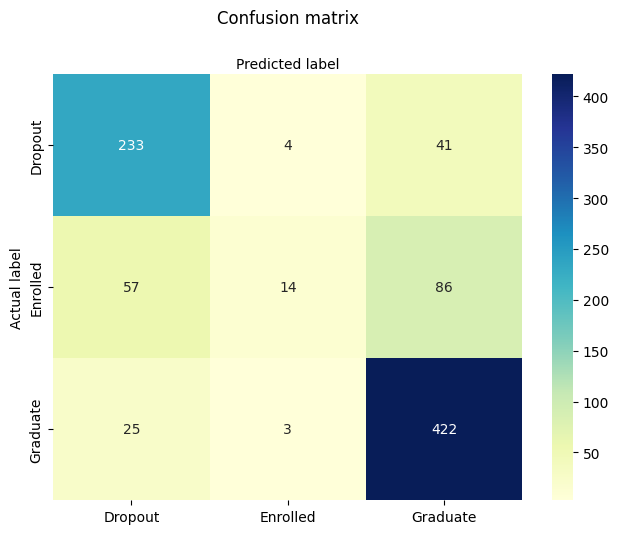

In [94]:
raw_outputs = trained_model(val_inputs)
_, predicted_classes = torch.max(raw_outputs, 1)
acc = metrics.accuracy_score(val_outputs, predicted_classes)

print(metrics.classification_report(val_outputs, predicted_classes))

from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(val_outputs, predicted_classes)
cnf_matrix

import seaborn as sns
class_names=['Dropout', 'Enrolled', 'Graduate'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='g', xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
